In [19]:
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt
from scipy import stats
import random
from pathlib import Path
from random import randrange
import pandas as pd

In [20]:
from recsim import document
from recsim import user
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

In [21]:
class LTSDocument(document.AbstractDocument):
    def __init__(
        self,
        doc_id,
        year,
        name,
        artists,
        popularity,
        valence,
        song_id,
        danceability,
        loudness,
        speechiness,
        acousticness,
        liveness,
        label,
        key,
        mode,
        instrumentalness,
        energy,
        tempo,
        duration_ms,
    ):
        self.year = year
        self.name = name
        self.artists = artists
        self.popularity = popularity
        self.valence = valence
        self.song_id = song_id
        self.danceability = danceability
        self.loudness = loudness
        self.speechiness = speechiness
        self.acousticness = acousticness
        self.liveness = liveness
        self.label = label
        self.key = key
        self.mode = mode
        self.instrumentalness = instrumentalness
        self.energy = energy
        self.tempo = tempo
        self.duration_ms = duration_ms

        # doc_id is an integer representing the unique ID of this document
        super(LTSDocument, self).__init__(doc_id)

    def create_observation(self):
        return self.popularity

        # return np.array([self.genre])

    @staticmethod
    def observation_space():
        return spaces.Discrete(10)
        # return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)

    def __str__(self):
        # return f"{self._doc_id}"
        return "Music {} with genre {}.".format(
            self._doc_id,
            self.year,
            self.name,
            self.artists,
            self.popularity,
            self.valence,
            self.song_id,
            self.danceability,
            self.loudness,
            self.speechiness,
            self.acousticness,
            self.liveness,
            self.label,
            self.key,
            self.mode,
            self.instrumentalness,
            self.energy,
            self.tempo,
            self.duration_ms,
        )

In [22]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
    DATASET_NAME = "Spotify"
    _DATA_PATH = Path(Path.home() / "rsys_data")
    _DATASET_PATH = _DATA_PATH / DATASET_NAME
    songs = pd.read_feather(_DATASET_PATH)

    def __init__(self, doc_ctor=LTSDocument, **kwargs):
        super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
        self._music_count = 0

    def sample_document(self, songs=songs):
        s = randrange(len(songs.index))
        doc_features = {}
        doc_features["doc_id"] = self._music_count
        doc_features["year"] = songs.loc[[s]].year
        doc_features["name"] = songs.loc[[s]].name
        doc_features["artists"] = songs.loc[[s]].artists
        doc_features["popularity"] = songs.loc[[s]].popularity
        doc_features["valence"] = songs.loc[[s]].valence
        doc_features["song_id"] = songs.loc[[s]].song_id
        doc_features["danceability"] = songs.loc[[s]].danceability
        doc_features["acousticness"] = songs.loc[[s]].acousticness
        doc_features["liveness"] = songs.loc[[s]].liveness
        doc_features["label"] = songs.loc[[s]].label
        doc_features["loudness"] = songs.loc[[s]].loudness
        doc_features["speechiness"] = songs.loc[[s]].speechiness
        doc_features["mode"] = songs.loc[[s]].mode
        doc_features["key"] = songs.loc[[s]].key
        doc_features["instrumentalness"] = songs.loc[[s]].instrumentalness
        doc_features["energy"] = songs.loc[[s]].energy
        doc_features["tempo"] = songs.loc[[s]].tempo
        doc_features["duration_ms"] = songs.loc[[s]].duration_ms
        self._music_count += 1
        return self._doc_ctor(**doc_features)

In [23]:
sampler = LTSDocumentSampler()
for i in range(10): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Music 0 with genre 88328    2000
Name: year, dtype: int64.
Music 1 with genre 144277    1962
Name: year, dtype: int64.
Music 2 with genre 69940    1994
Name: year, dtype: int64.
Music 3 with genre 126147    1946
Name: year, dtype: int64.
Music 4 with genre 4084    1942
Name: year, dtype: int64.
Music 5 with genre 54644    2007
Name: year, dtype: int64.
Music 6 with genre 97604    1964
Name: year, dtype: int64.
Music 7 with genre 22928    1941
Name: year, dtype: int64.
Music 8 with genre 155871    1940
Name: year, dtype: int64.
Music 9 with genre 80287    1959
Name: year, dtype: int64.
Documents have observation space: Discrete(10) 
An example realization is:  7929    32
Name: popularity, dtype: int64


In [24]:
class LTSUserState(user.AbstractUserState):
    def __init__(
        self,
        age,
        gender,
        valence,
        danceability,
        loudness,
        speechiness,
        acousticness,
        liveness,
        net_genre_exposure,
        sensitivity,
        time_budget,
        label,
        mode,
        key,
        duration_ms,
        tempo,
        energy,
        instrumentalness,
        observation_noise_stddev=0.1,
    ):
        ## Transition model parameters
        ## State variables
        ##############################
        self.age = age
        self.gender = gender
        self.sensitivity = sensitivity
        self.valence = valence
        self.danceability = danceability

        ## Engagement parameters
        self.loudness = loudness
        self.speechiness = speechiness
        self.acousticness = acousticness
        self.liveness = liveness

        self.label = label
        self.mode = mode
        self.key = key
        self.duration_ms = duration_ms
        self.tempo = tempo
        self.energy = energy
        self.instrumentalness = instrumentalness
        self.net_genre_exposure = net_genre_exposure
        self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_genre_exposure))
        self.time_budget = time_budget

        # Noise
        self._observation_noise = observation_noise_stddev

    def create_observation(self):
        """User's state is not observable."""
        clip_low, clip_high = (
            -1.0 / (1.0 * self._observation_noise),
            1.0 / (1.0 * self._observation_noise),
        )
        noise = stats.truncnorm(
            clip_low, clip_high, loc=0.0, scale=self._observation_noise
        ).rvs()
        noisy_sat = self.satisfaction + noise
        return np.array(
            [
                noisy_sat,
            ]
        )

    @staticmethod
    def observation_space():
        return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)

    # scoring function for use in the choice model -- the user is more likely to
    # click on more chocolatey content.
    def score_document(self, doc_obs):
        return 1 - doc_obs

In [25]:
class LTSStaticUserSampler(user.AbstractUserSampler):
    _state_parameters = None

    def __init__(
        self,
        user_ctor=LTSUserState,
        sensitivity=0.01,
        time_budget=30,
        #  age=np.random.random_integers(20,60),
        #  gender=np.random.random_integers(1),
        #  valence=np.random.uniform(0.0,1.0),
        #  danceability=np.random.normal(0.5373955347986852,0.17613721955546152),
        #  loudness=np.random.gumbel(0.8004193058243345,0.0690033070151354),
        #  speechiness=np.random.laplace(0.045,0.06335336735949558),
        #  acousticness=np.random.uniform(0.0,0.996),
        #  liveness=np.random.laplace(0.136,0.11092283130094402),
        #  mood=np.random.random_integers(3),
        **kwargs
    ):
        self._state_parameters = {
            "sensitivity": sensitivity,
            "time_budget": time_budget,
        }  #'age' : age,
        #                           'gender_group' : gender_group,
        #                           'valence': valence,
        #                           'danceability': danceability,
        #                           'loudness': loudness,
        #                           'speechiness': speechiness,
        #                           'acousticness': acousticness,
        #                           'liveness': liveness,
        #                           'mood': mood

        super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

    def sample_user(self):
        self._state_parameters["age"] = np.random.random_integers(20, 60)
        self._state_parameters["gender"] = np.random.random_integers(2)
        self._state_parameters["valence"] = np.random.uniform(0.0, 1.0)
        self._state_parameters["danceability"] = np.random.normal(
            0.5373955347986852, 0.17613721955546152
        )
        self._state_parameters["loudness"] = np.random.gumbel(
            0.8004193058243345, 0.0690033070151354
        )
        self._state_parameters["speechiness"] = np.random.laplace(
            0.045, 0.06335336735949558
        )
        self._state_parameters["acousticness"] = np.random.uniform(0.0, 0.996)
        self._state_parameters["liveness"] = np.random.laplace(
            0.136, 0.11092283130094402
        )
        self._state_parameters["label"] = np.random.random_integers(4)
        self._state_parameters["mode"] = np.random.random_integers(2)
        self._state_parameters["key"] = np.random.random_integers(12)
        self._state_parameters["duration_ms"] = np.random.laplace(
            207467.0, 69419.7225773939
        )
        self._state_parameters["tempo"] = np.random.gumbel(
            102.26991914996023, 27.79478925686645
        )
        self._state_parameters["energy"] = np.random.uniform(0.0, 1.0)
        self._state_parameters["instrumentalness"] = np.random.exponential(0.167)

        starting_nke = self._rng.random_sample() - 0.5
        self._state_parameters["net_genre_exposure"] = starting_nke
        # starting_nke = ((self._rng.random_sample() - .5) *
        #                 (1 / (1.0 - self._state_parameters['memory_discount'])))
        # self._state_parameters['net_genre_exposure'] = starting_nke
        return self._user_ctor(**self._state_parameters)

/tmp/ipykernel_632388/2514707847.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_632388/2514707847.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_632388/2514707847.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_632388/2514707847.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)


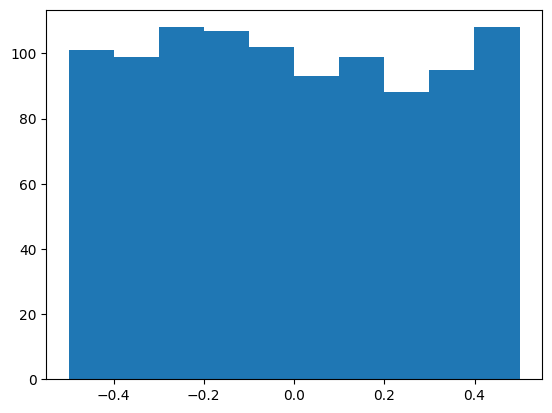

In [26]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
  sampled_user = sampler.sample_user()
  starting_nke.append(sampled_user.net_genre_exposure)
_ = plt.hist(starting_nke)

In [27]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

In [28]:
def user_init(self,
              slate_size,
              seed=0):

  super(LTSUserModel,
        self).__init__(LTSResponse,
                       LTSStaticUserSampler(LTSUserState,
                                            seed=seed), slate_size)
  self.choice_model = MultinomialLogitChoiceModel({})

In [29]:
def simulate_response(self, slate_documents):
  # List of empty responses
  responses = [self._response_model_ctor() for _ in slate_documents]
  # Get click from of choice model.
  self.choice_model.score_documents(
    self._user_state, [doc.create_observation() for doc in slate_documents])
  scores = self.choice_model.scores
  selected_index = self.choice_model.choose_item()
  # Populate clicked item.
  print(slate_documents[selected_index])
  self._generate_response(slate_documents[selected_index],
                          responses[selected_index])
  return responses

def generate_response(self, doc, response):
  response.clicked = True
  # linear interpolation between choc and kale.
  if (self._user_state.age>40):
    engagement_loc = 1/abs(((doc.acousticness-self._user_state.acousticness)+(doc.liveness-self._user_state.liveness)))
    engagement_loc *= self._user_state.satisfaction
    engagement_scale = (doc.acousticness * (self._user_state.label+1)
                      + ((1 - doc.liveness)
                          * (self._user_state.label+1)))
  else:
    engagement_loc = 1/abs((doc.danceability-self._user_state.danceability)+(doc.valence-self._user_state.valence))
    engagement_loc *= self._user_state.satisfaction
    engagement_scale = (doc.danceability* (self._user_state.label+1)
                      + ((1 - doc.valence)
                          * (self._user_state.label+1)))
  log_engagement = np.random.normal(loc=engagement_loc,
                                    scale=engagement_scale)
  response.engagement = np.exp(log_engagement)

def update_state(self, slate_documents, responses):
  for doc, response in zip(slate_documents, responses):
    if response.clicked:
      label = np.random.normal(scale=self._user_state.label)
      net_genre_exposure = (self._user_state.valence
                                * self._user_state.danceability
                                + 2.0 * (doc.danceability - 0.5)
                                + label
                              )
      self._user_state.net_genre_exposure = net_genre_exposure
      satisfaction = 1 / (1.0 + np.exp(-self._user_state.label
                                        * net_genre_exposure)
                          )
      self._user_state.satisfaction = satisfaction
      self._user_state.time_budget -= 1
      return

In [30]:
DATASET_NAME = "Spotify"
_DATA_PATH = Path(Path.home() / "rsys_data")
_DATASET_PATH = _DATA_PATH / DATASET_NAME
songs = pd.read_feather(_DATASET_PATH)
print(songs.dtypes)
songs.loc[[111930]]

year                  int64
name                 object
artists              object
popularity            int64
valence             float64
song_id              object
danceability        float64
loudness            float64
speechiness         float64
acousticness        float64
liveness            float64
label                 int32
key                   int64
mode                  int64
tempo               float64
instrumentalness    float64
energy              float64
duration_ms           int64
dtype: object


,year,name,artists,popularity,valence,song_id,danceability,loudness,speechiness,acousticness,liveness,label,key,mode,tempo,instrumentalness,energy,duration_ms
111930,1955,I Can't Believe You're In Love With Me,['Oscar Peterson'],3,0.375,2wG4hK6jTtEcC3A3MiBRs6,0.778,0.659494,0.0588,0.987,0.103,2,5,0,119.552,0.851,0.111,214423


In [31]:
def is_terminal(self):
  """Returns a boolean indicating if the session is over."""
  return self._user_state.time_budget <= 0

In [32]:
LTSUserModel = type("LTSUserModel", (user.AbstractUserModel,),
                    {"__init__": user_init,
                     "is_terminal": is_terminal,
                     "update_state": update_state,
                     "simulate_response": simulate_response,
                     "_generate_response": generate_response})

In [33]:
slate_size = 3
num_candidates = 10
ltsenv = environment.Environment(
            LTSUserModel(slate_size),
            LTSDocumentSampler(),
            num_candidates,
            slate_size,
            resample_documents=True)

/tmp/ipykernel_632388/2514707847.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_632388/2514707847.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_632388/2514707847.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_632388/2514707847.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)


In [34]:
def clicked_engagement_reward(responses):
  reward = 0.0
  for response in responses:
    if response.clicked:
      reward += response.engagement
  return reward

In [35]:

lts_gym_env = recsim_gym.RecSimGymEnv(ltsenv, clicked_engagement_reward)

In [36]:
observation_0 = lts_gym_env.reset()
print('Observation 0')
print('Available documents')
doc_strings = ['music_id ' + key + " index " + str(value) for key, value
               in observation_0['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(observation_0['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['music_id ' + key + " index " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
music_id 10 index 54823    59
Name: popularity, dtype: int64
music_id 11 index 146173    19
Name: popularity, dtype: int64
music_id 12 index 162516    24
Name: popularity, dtype: int64
music_id 13 index 6102    19
Name: popularity, dtype: int64
music_id 14 index 85206    39
Name: popularity, dtype: int64
music_id 15 index 30487    45
Name: popularity, dtype: int64
music_id 16 index 114330    24
Name: popularity, dtype: int64
music_id 17 index 29197    46
Name: popularity, dtype: int64
music_id 18 index 14749    60
Name: popularity, dtype: int64
music_id 19 index 156816    0
Name: popularity, dtype: int64
Noisy user state observation
[0.45249036]
Music 11 with genre 146173    1972
Name: year, dtype: int64.
Observation 1
Available documents
music_id 20 index 107988    59
Name: popularity, dtype: int64
music_id 21 index 72912    48
Name: popularity, dtype: int64
music_id 22 index 2250    23
Name: popularity, dtype: int64
music_id 23 index 160426    25
Nam

/tmp/ipykernel_632388/2514707847.py:36: DeprecationWarning: This function is deprecated. Please call randint(20, 60 + 1) instead
  self._state_parameters["age"] = np.random.random_integers(20, 60)
/tmp/ipykernel_632388/2514707847.py:37: DeprecationWarning: This function is deprecated. Please call randint(1, 2 + 1) instead
  self._state_parameters["gender"] = np.random.random_integers(2)
/tmp/ipykernel_632388/2514707847.py:52: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  self._state_parameters["label"] = np.random.random_integers(4)
/tmp/ipykernel_632388/2514707847.py:54: DeprecationWarning: This function is deprecated. Please call randint(1, 12 + 1) instead
  self._state_parameters["key"] = np.random.random_integers(12)
